## 패키지 불러오기

In [ ]:
import torch # Pytorch의 핵심 기능 제공
import torch.nn as nn # 신경망 모델을 만들 때 사용하는 모듈
import torch.optim as optim # 최적화 알고리즘(Optimizer) 사용을 위한 모듈 / 파라미터 업데이트
import torch.nn.functional as F # 활성화 함수, 손실함수 등 제공
import torchvision # 이미지 처리 라이브러리
import torchvision.transforms as transforms # 데이터 전처리를 위한 이미지 변환 도구
from torch.utils.data import DataLoader, Subset # 미니배치로 나누고, 특정 샘플만 선택할 수 있도록
import numpy as np # 수학 연산 및 배열 조작

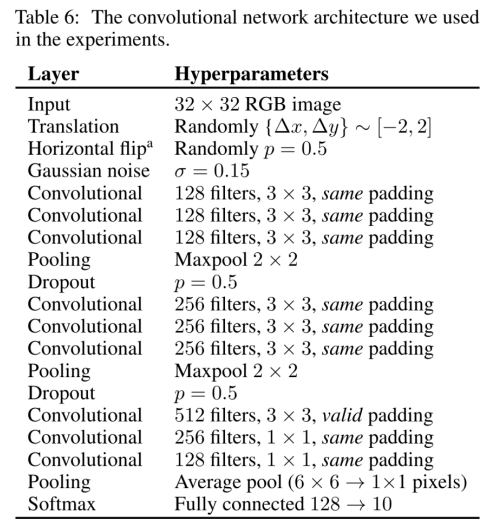

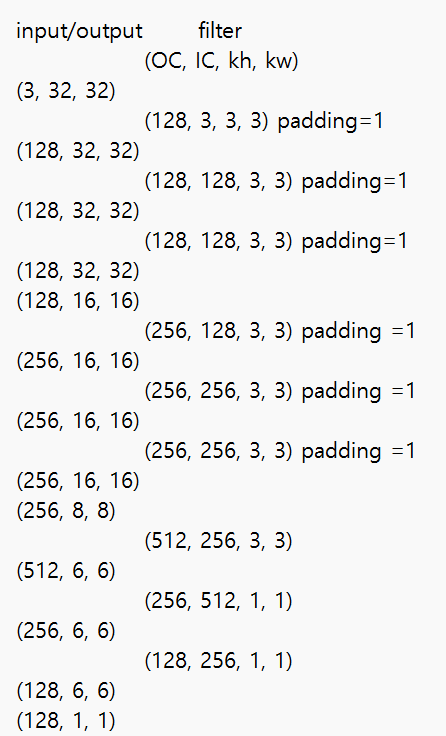

## CNN 모델 정의

In [ ]:
class CNNModel(nn.Module): # 상속 받아옴
  def __init__(self):
    super(CNNModel, self).__init__() # 상속 받은 nn.model 생성자

     # 첫 번째 합성곱 블록 (입력: 3채널, 출력: 128채널)
    self.conv1a=nn.Conv2d(in_channels=3, out_channels=128, kernel_size=3, padding=1)
    self.conv1b=nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)
    self.conv1c=nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)
     # 두 번째 합성곱 블록 (입력: 128채널, 출력: 256채널)
    self.conv2a=nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
    self.conv2b=nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
    self.conv2c=nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
     # 세 번째 합성곱 블록 (입력: 256채널, 출력: 512 → 256 → 128채널)
    self.conv3a=nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3)
    self.conv3b=nn.Conv2d(in_channels=512, out_channels=256, kernel_size=1)
    self.conv3c=nn.Conv2d(in_channels=256, out_channels=128, kernel_size=1)

    # 완전 연결층 (Dense Layer)
    self.dense=nn.Linear(in_features=128, out_features=10)
    # 드롭아웃
    self.drop1=nn.Dropout(0.5)
    self.drop2=nn.Dropout(0.5)
    # 풀링 레이어
    self.maxpool=nn.MaxPool2d(2)
    self.avgpool=nn.AvgPool2d(6)
    #활성화 함수
    self.relu=nn.LeakyReLU(negative_slope=0.1)

  def forward(self, x):
    x=self.relu(self.conv1a(x))
    x=self.relu(self.conv1b(x))
    x=self.relu(self.conv1c(x))
    x=self.drop1(self.maxpool(x))
    x=self.relu(self.conv2a(x))
    x=self.relu(self.conv2b(x))
    x=self.relu(self.conv2c(x))
    x=self.drop2(self.maxpool(x))
    x=self.relu(self.conv3a(x))
    x=self.relu(self.conv3b(x))
    x=self.relu(self.conv3c(x))
    x=self.avgpool(x)
    x=x.reshape(-1, 128) # (batch_size, 128, 1, 1) → (batch_size, 128)
    x=self.dense(x)
    return x

## train(labeled, unlabeled), test 데이터 가져오기

In [ ]:
# 데이터 변환 정의 (훈련 데이터 전처리)
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(), # 50% 확률로 이미지 좌우 반전
    transforms.RandomCrop(32, padding=4), # 32x32 크기로 랜덤한 위치에서 잘라내기
    transforms.ToTensor() # 이미지를 Pytorch 텐서로 변환
])

# CIFAR-10 데이터셋 로드 (훈련 및 테스트 데이터)
trainset = torchvision.datasets.CIFAR10(root='.', train=True, download=True,
                                        transform=train_transform)  # 훈련 데이터에 변환 적용
testset = torchvision.datasets.CIFAR10(root='.', train=False, download=True,
                                       transform=transforms.ToTensor()) # 테스트 데이터는 기본 변환만 적
# 라벨이 있는 데이터 개수 설정
num_labeled = 4000

# 전체 데이터셋의 인덱스 생성
indices = np.arange(len(trainset))

# 라벨이 있는 데이터와 없는 데이터의 인덱스 분할
labeled_indices=indices[:num_labeled]
unlabeled_indices=indices[num_labeled:]

# 라벨이 있는 데이터와 없는 데이터를 Subset으로 생성
labeled_dataset=Subset(trainset, labeled_indices)
unlabeled_dataset=Subset(trainset, unlabeled_indices)

batch_size=64

# 데이터 로더 생성 (미니배치 단위로 데이터를 불러옴)
labeled_loader = DataLoader(labeled_dataset, batch_size=batch_size, shuffle=True)
unlabeled_loader = DataLoader(unlabeled_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False)

##모델과 하이퍼파라미터 초기화

In [ ]:
student_model = CNNModel().cuda() # 학습을 통해 최적화 되는 모델
teacher_model = CNNModel().cuda() # 학생 모델의 지식을 전달 받으며, 학생 모델의 이동평균(EMA)로 업데이트

# 동일한 초기 모델
teacher_model.load_state_dict(student_model.state_dict()) #  student_model의 가중치를 teacher_model에 복사

# Adam optimizer를 사용해 학생 모델의 가중치 업데이트
# Teacher 모델은 옵티마이저가 아닌 EMA 방식으로 업데이트!!
optimizer = optim.Adam(student_model.parameters(), lr=0.001)

# EMA 계수 설정 (α)
ema_decay = 0.995

# Consistency Weight 설정 (λ)
consistency_weight = 0.1

## labeled 데이터 훈련

모든 데이터가 라벨이 있는 경우에는 Mean Teacher 모델을 사용할 필요가 없음

In [ ]:
for epoch in range(70):  # 총 50번의 학습(epoch) 수행
    print(f"Epoch {epoch+1}")
    student_model.train()  # 학생 모델을 학습 모드로 설정

    for labeled_data in labeled_loader:  # 라벨이 있는 데이터셋 반복
        inputs_l, targets_l = labeled_data  # 입력 데이터와 라벨 가져오기
        inputs_l, targets_l = inputs_l.cuda(), targets_l.cuda()  # GPU로 이동

        outputs_l = student_model(inputs_l)  # 학생 모델을 통해 예측값 계산

        supervised_loss = F.cross_entropy(outputs_l, targets_l)  # 지도학습 손실(Cross-Entropy Loss) 계산

        loss = supervised_loss  # 현재는 지도학습 손실만 사용

        optimizer.zero_grad()  # 기존의 그래디언트 초기화 (역전파 누적 방지)
        loss.backward()  # 역전파(Backpropagation)
        optimizer.step()  # 옵티마이저를 통해 가중치 업데이트


Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19
Epoch 20
Epoch 21
Epoch 22
Epoch 23
Epoch 24
Epoch 25
Epoch 26
Epoch 27
Epoch 28
Epoch 29
Epoch 30
Epoch 31
Epoch 32
Epoch 33
Epoch 34
Epoch 35
Epoch 36
Epoch 37
Epoch 38
Epoch 39
Epoch 40
Epoch 41
Epoch 42
Epoch 43
Epoch 44
Epoch 45
Epoch 46
Epoch 47
Epoch 48
Epoch 49
Epoch 50
Epoch 51
Epoch 52
Epoch 53
Epoch 54
Epoch 55
Epoch 56
Epoch 57
Epoch 58
Epoch 59
Epoch 60
Epoch 61
Epoch 62
Epoch 63
Epoch 64
Epoch 65
Epoch 66
Epoch 67
Epoch 68
Epoch 69
Epoch 70


## 모델 평가 ( test 데이터가 모두 라벨드인 경우)

In [ ]:
# 평가 모드로 설정
student_model.eval()

correct, total = 0, 0

with torch.no_grad(): # 그래디언트 계산 비활성화
  for images, labels in test_loader: # 미니 배치 단위로 이미지와 라벨 가져옴
    images, labels = images.cuda(), labels.cuda()
    predicted = student_model(images).argmax(dim=1) # 가장 높은 확률을 가진 클래스의 인덱스
    total += labels.size(0)  # labels.size(0)은 현재 배치에서의 샘플 갯수. 모두 더해 총 데이터 갯수
    correct += (predicted == labels).sum()

print(f'Accuracy of student model on CIFAR-10: {100 * correct/total:.2f}%')

Accuracy of student model on CIFAR-10: 75.28%


## ★ Unlabeled 데이터 훈련 ★

Mean Teacher 모델 필요



In [ ]:
# 초기 학생 모델을 교사 모델로 복사
teacher_model.load_state_dict(student_model.state_dict())

# 학습 루프
for epoch in range(70):  # 총 70번의 학습(epoch) 수행
    print(f"Epoch {epoch+1}")
    student_model.train()
    teacher_model.train()  # 학습 모드로 설정

    for (labeled_data, unlabeled_data) in zip(labeled_loader, unlabeled_loader):  # 라벨이 있는 데이터셋 반복
        inputs_l, targets_l = labeled_data  # 입력 데이터와 라벨 가져오기
        inputs_l, targets_l = inputs_l.cuda(), targets_l.cuda()  # GPU로 이동
        inputs_u, _ = unlabeled_data
        inputs_u = inputs_u.cuda()

        outputs_l = student_model(inputs_l)  # 학생 모델을 통해 예측값 계산
        outputs_u_student = student_model(inputs_u)
        outputs_u_teacher = teacher_model(inputs_u).detach()  # 교사 모델의 출력은 detach()로 분리

        supervised_loss = F.cross_entropy(outputs_l, targets_l)  # 지도학습 손실(Cross-Entropy Loss) 계산
        consistency_loss = F.mse_loss(F.softmax(outputs_u_student, dim=1),
                                      F.softmax(outputs_u_teacher, dim=1))  # 학생 모델과 교사 모델 간의 일관성 손실

        loss = supervised_loss + consistency_loss + consistency_weight * consistency_loss  # 총 손실 계산

        optimizer.zero_grad()  # 기존의 그래디언트 초기화 (역전파 누적 방지)
        loss.backward()  # 역전파(Backpropagation)
        optimizer.step()  # 옵티마이저를 통해 가중치 업데이트

        # EMA 업데이트 (학생 모델의 가중치로 교사 모델을 업데이트)
        with torch.no_grad():
            for teacher_param, student_param in zip(teacher_model.parameters(), student_model.parameters()):
                teacher_param.data.mul_(ema_decay).add_((1 - ema_decay) * student_param.data)


Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19
Epoch 20
Epoch 21
Epoch 22
Epoch 23
Epoch 24
Epoch 25
Epoch 26
Epoch 27
Epoch 28
Epoch 29
Epoch 30
Epoch 31
Epoch 32
Epoch 33
Epoch 34
Epoch 35
Epoch 36
Epoch 37
Epoch 38
Epoch 39
Epoch 40
Epoch 41
Epoch 42
Epoch 43
Epoch 44
Epoch 45
Epoch 46
Epoch 47
Epoch 48
Epoch 49
Epoch 50
Epoch 51
Epoch 52
Epoch 53
Epoch 54
Epoch 55
Epoch 56
Epoch 57
Epoch 58
Epoch 59
Epoch 60
Epoch 61
Epoch 62
Epoch 63
Epoch 64
Epoch 65
Epoch 66
Epoch 67
Epoch 68
Epoch 69
Epoch 70


In [ ]:
# 평가 모드로 설정
student_model.eval()
teacher_model.eval()

correct_s, total_s = 0, 0
correct_t, total_t = 0, 0

with torch.no_grad():  # 그래디언트 계산 비활성화
  for images, labels in test_loader:  # 미니 배치 단위로 이미지와 라벨 가져옴
    images, labels = images.cuda(), labels.cuda()

    predicted_s = student_model(images).argmax(dim=1)  # 학생 모델 예측값
    predicted_t = teacher_model(images).argmax(dim=1)  # 교사 모델 예측값

    total_s += labels.size(0)
    total_t += labels.size(0)

    correct_s += (predicted_s == labels).sum()
    correct_t += (predicted_t == labels).sum()

print(f'Accuracy of student model on CIFAR-10: {100 * correct_s / total_s:.2f}%')
print(f'Accuracy of teacher model on CIFAR-10: {100 * correct_t / total_t:.2f}%')


Accuracy of student model on CIFAR-10: 76.11%
Accuracy of teacher model on CIFAR-10: 79.16%
